In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('conso-hdf.csv', index_col=0)
df.index = pd.to_datetime(df.date)
df_day = df.resample('D').mean()
df_month = df.resample('M').mean()

/tmp/ipykernel_21664/1254934.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_day = df.resample('D').mean()
/tmp/ipykernel_21664/1254934.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month = df.resample('M').mean()


# 3.1 Approche statistique avec statmodels

### 1. Sachant que les modèles ARIMA et SARIMA sont des régression linéaires qui prennent comme variables explicatives les “lags” (les états précédents) de notre time série. Pourquoi est-on si attaché au fait que notre série temporelle soit stationnaire?

Car dans une régression linéaire, les régresseurs doivent être indépendants les uns des autres. Or, dans une time series non stationnaire, les états précédents ne sont pas indépendants les uns des autres. 

### 2. Qu’est qu’un modèle AR, à quoi correspond le paramètre p ?

AR = autorégressif, il fait des prédictions basées sur ses états passés.   
p est le nombre d'états passés à considérer pour effectuer des prédictions.

### 3. Qu’est ce qu’un modèle MA, à quoi correspond le paramètre q?


MA = Moving average, Ajuste le modèle en fonction des erreurs de prédiction moyennes des q observations précédentes.  
q est donc le nombre d'observations pour obtenir une erreur nulle.

### 4. Qu’est ce que le modèle ARIMA et à quoi correspond le paramètre d?

ARIMA est une combinaison de AR et MA et introduit le fait de pouvoir utiliser ARMA sur une série non stationnaire en ajoutant la différenciation, c'est à dire soustraire un état passé à l'état actuel. Cela permet de rendre une série stationnaire.
d est le nombre de différenciation à réaliser pour que la série soit stationnaire. 

### 5. Qu’est ce que le modèle SARIMA et à quoi correspond le paramètre s?

Sarima est une évolution d'ARIMA qui permet de prendre en compte le fait que la série présente une saisonnalité et la faire disparaître. 
s correspond au nombre d'observations dans chaque 'saison' ou période de la saisonnalité. 

### 6. Déterminer les paramètres s, d, q, p  à l’aide des graphiques d’autocorrélation et d’autocorrélation partielle, ainsi qu’à l’aide des graphiques de la première partie.
- Déterminer d’abord s et appliquer la désaisonnalisation
- Sur la série désaisonnalisée recherchez d et détrendez
- Sur la série détrendée, recherchez q et p


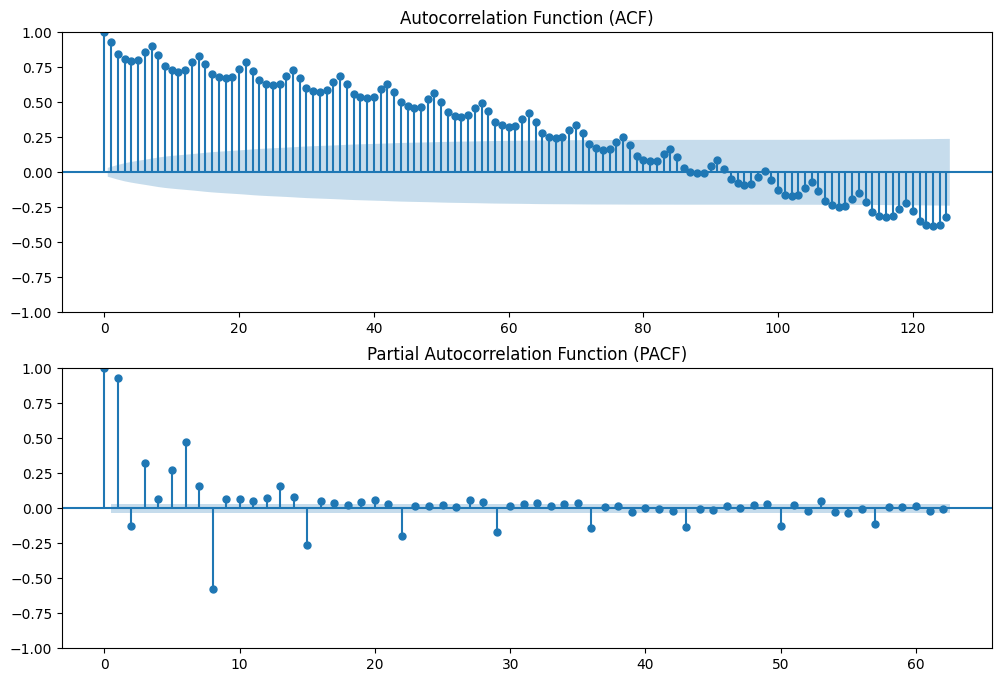

In [2]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Supposons que df_month soit votre série temporelle
# Créez une figure avec deux sous-graphiques
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Tracez l'ACF sur le premier sous-graphique
plot_acf(df_day,lags=125, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Tracez le PACF sur le deuxième sous-graphique
plot_pacf(df_day,lags=62,ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

# Affichez la figure
plt.show()


In [3]:
s = 12

In [4]:
serie_desaisonnalisee = df_day['consommation_brute_electricite_rte'].rolling(window=365).mean()

In [5]:
serie_desaisonnalisee.dropna(inplace=True)

In [6]:
serie_desaisonnalisee.to_csv('serie_desaisonnalisee.csv')

/tmp/ipykernel_21664/458271479.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


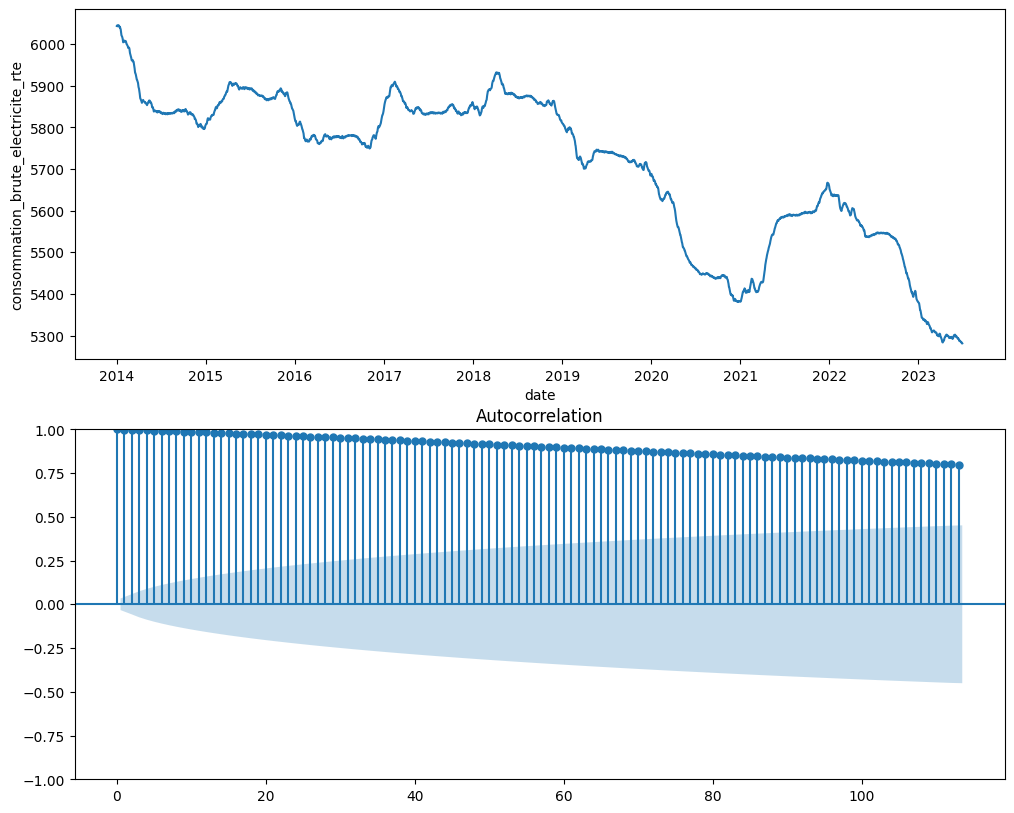

In [7]:
import seaborn as sns
import statsmodels.api as sm

fig = plt.figure(figsize=(12, 10))
subplot1 = fig.add_subplot(211)
subplot2 = fig.add_subplot(212)
sns.lineplot(serie_desaisonnalisee, ax=subplot1)
sm.graphics.tsa.plot_acf(serie_desaisonnalisee, lags=113, ax=subplot2) 
fig.show()

In [8]:
serie_detrendee = serie_desaisonnalisee-serie_desaisonnalisee.shift(1)
serie_detrendee.dropna(inplace=True)

/tmp/ipykernel_21664/2680710081.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


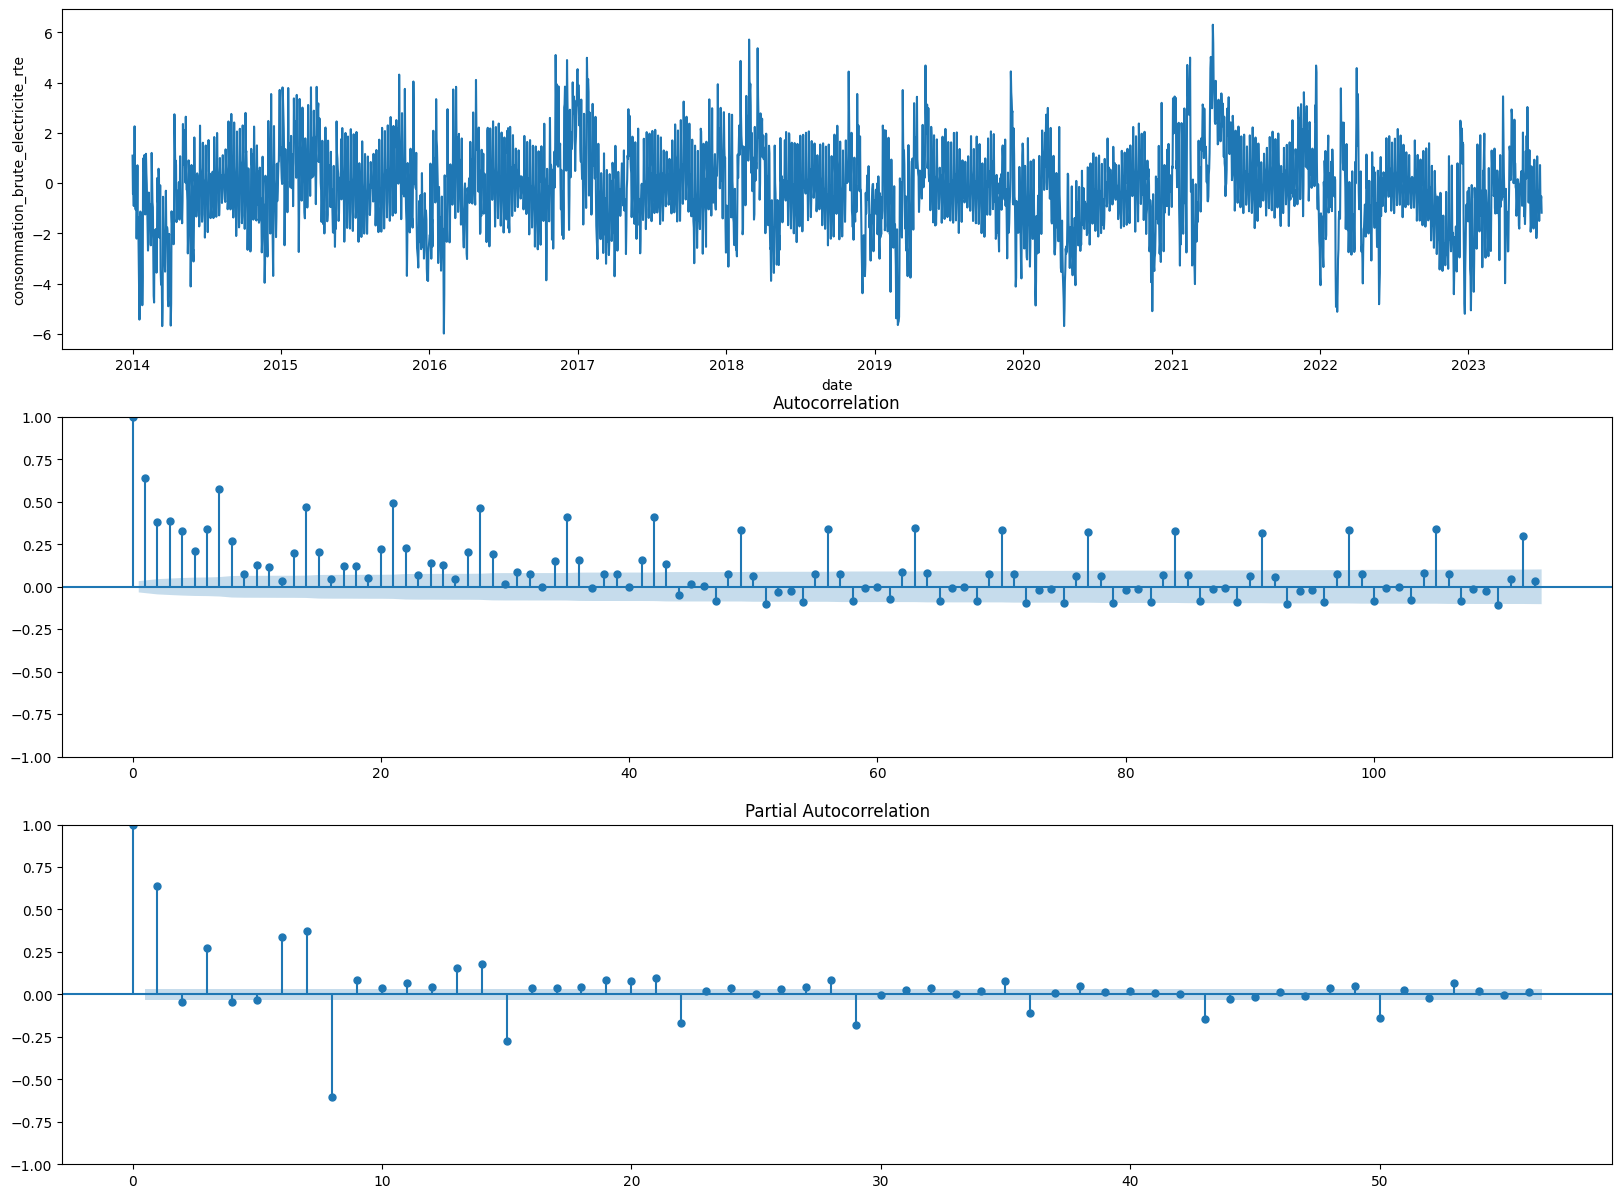

In [9]:
import seaborn as sns
import statsmodels.api as sm

fig, (subplot1, subplot2, subplot3) = plt.subplots(3, 1, figsize=(20, 15))
sns.lineplot(serie_detrendee, ax=subplot1)
sm.graphics.tsa.plot_acf(serie_detrendee, lags=113, ax=subplot2) 
sm.graphics.tsa.plot_pacf(serie_detrendee, lags=56, ax=subplot3)
fig.show()

In [10]:
d = 1

D'après le graphique d'auto-corrélation partielle, p = 1 (la première barre c'est yt, la deuxième yt-1, on ne garde que celle-là car yt-2 n'est pas significatif).  
D'après le graphique d'auto-corrélation, q = 8.

### 7. A l’aide statmodels et dans une approche statistique (sans train/test/split), lancez un modèle ARIMA sur la série désaisonnalisée. 
- Est ce que tous les paramètres sont significatifs
- Qu’est ce que l’AIC?
- Essayez d’améliorer votre modèle en modifiant les paramètres non significatifs et en vous basant sur le critère de l’AIC.


In [44]:
import statsmodels.api as sm

arima_model = sm.tsa.ARIMA(serie_desaisonnalisee, order=(3, 1, 9))

arima_model = arima_model.fit()

# Afficher un résumé du modèle
print(arima_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:     consommation_brute_electricite_rte   No. Observations:                 3469
Model:                                 ARIMA(3, 1, 9)   Log Likelihood               -4460.695
Date:                                Mon, 18 Sep 2023   AIC                           8947.390
Time:                                        15:19:49   BIC                           9027.357
Sample:                                    12-31-2013   HQIC                          8975.943
                                         - 06-30-2023                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5286      0.007     80.181      0.000       0.516       0.542
ar.

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [12]:
# arima_model = sm.tsa.ARIMA(serie_desaisonnalisee, order=(3, 1, 2))

# arima_model = arima_model.fit()

# # Afficher un résumé du modèle
# print(arima_model.summary())

Si on enlève ma.L3, plus aucun coefficient n'est significatif.

L'AIC = Aikaike Information Criterion. Il s'agit d'un critère d'évaluation du modèle qui tient compte de sa complexité (du nombre de paramètres), de sa capacité à s'ajuster aux données et qui représente la perte d'information dans la modélisation des données. L'objectif est donc de le minimiser. L'AIC favorise les modèles qui s'ajustent bien aux données, tout en pénalisant la complexité. Il recherche donc un équilibre entre ajustement aux données et complexité.

In [13]:
# arima_model = sm.tsa.ARIMA(serie_desaisonnalisee, order=(2,1,3))

# arima_model = arima_model.fit()

# # Afficher un résumé du modèle
# print(arima_model.summary())

In [14]:
# arima_model = sm.tsa.ARIMA(serie_desaisonnalisee, order=(2,1,2))

# arima_model = arima_model.fit()

# # Afficher un résumé du modèle
# print(arima_model.summary())

En faisant varier les paramètres, les coefficients ne sont pas significatifs et l'AIC augmente. Le premier modèle était le plus performant.

### 8. Affichez les résidus du meilleurs des modèles que vous avez jusqu’à présent, pourquoi recherche t-on un bruit blanc ou l’absence de pattern dans ces résidus? Que constatez vous pour le graphique affiché?

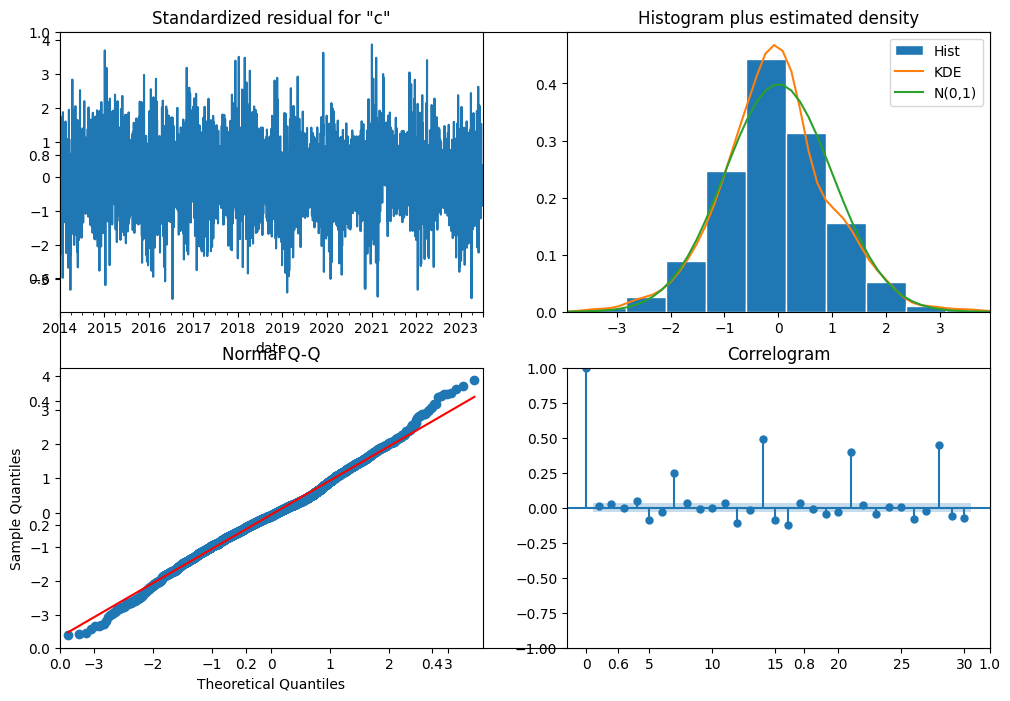

In [15]:
# Affichez les diagnostics des résidus avec une taille de figure personnalisée
fig, ax = plt.subplots(figsize=(12, 8))
residuals = arima_model.plot_diagnostics(fig=fig, lags=30)
plt.show()

On recherche un bruit blanc ou l'absence de pattern pour être sûrs que le modèle capture la structure des données. Si c'est le cas, les erreurs (les résidus) doivent être aléatoires : ne pas présenter de pattern, ressembler à un bruit blanc. Ca va influencer la qualité des prédictions. Le modèle ARIMA est un modèle de régression qui repose sur les hypothèses d'homoscédasticité (variance constante des résidus) et normalité des résidus. Ici, on peut voir que les résidus suivent une distribution normale. Cependant, on peut se demander si la variance est vraiment constante et les autocorrélations dépassent parfois le seuil de significativité, ce qui pourrait laisser supposer que des corrélations existent entre les différents lags. 

### 9. Affichez les prédictions du meilleur de vos modèles. Qu’en pensez vous?

In [16]:
serie_desaisonnalisee.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 3469 entries, 2013-12-31 to 2023-06-30
Freq: D
Series name: consommation_brute_electricite_rte
Non-Null Count  Dtype  
--------------  -----  
3469 non-null   float64
dtypes: float64(1)
memory usage: 54.2 KB


In [17]:
predictions = arima_model.predict(start=1)


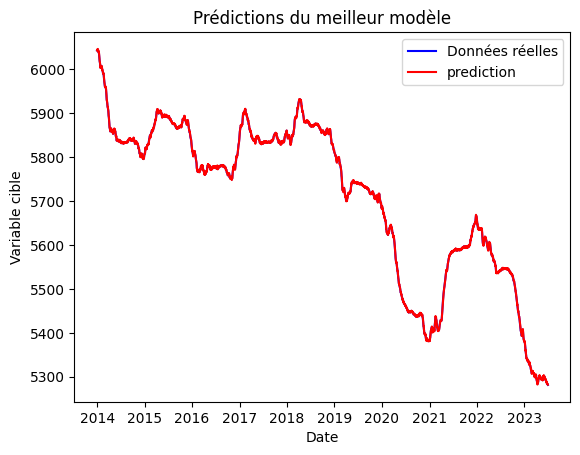

In [18]:
import matplotlib.pyplot as plt

# Tracez les données réelles
plt.plot(serie_desaisonnalisee,label='Données réelles', color='blue')

# Tracez les prédictions
plt.plot(serie_desaisonnalisee.index[1:], predictions,label='prediction',color='red')
# Personnalisez le graphique
plt.xlabel('Date')
plt.ylabel('Variable cible')
plt.title('Prédictions du meilleur modèle')
plt.legend()
plt.show()


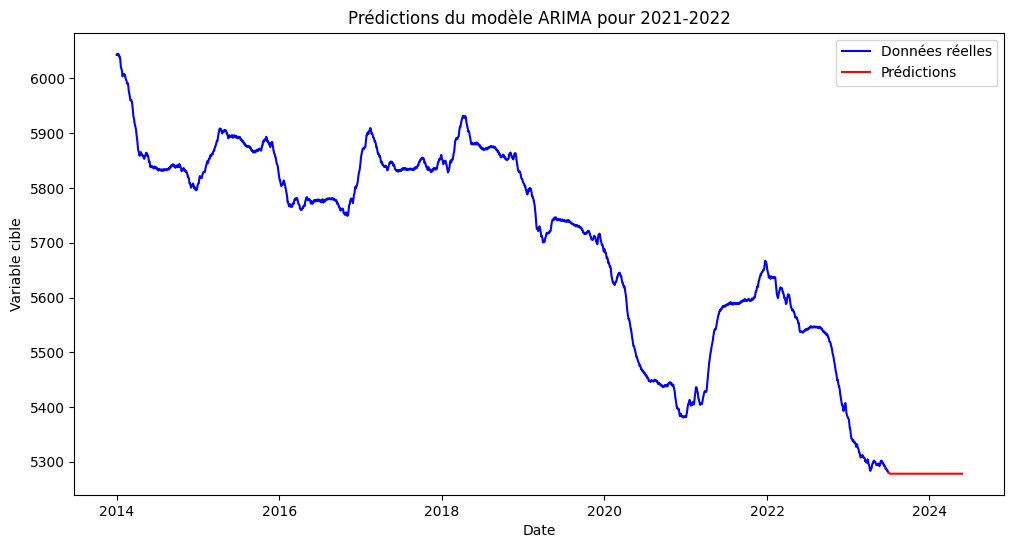

In [19]:
predictions = arima_model.predict(start=3469,end=3800)

# Afficher les prédictions par rapport aux données réelles
plt.figure(figsize=(12, 6))
plt.plot(serie_desaisonnalisee.index, serie_desaisonnalisee, label='Données réelles', color='blue')
plt.plot(predictions.index, predictions.values, label='Prédictions', color='red')
plt.xlabel('Date')
plt.ylabel('Variable cible')
plt.title('Prédictions du modèle ARIMA pour 2021-2022')
plt.legend()
plt.show()

### 10. Entrainez le même modèle mais cette fois uniquement sur les dates de 2014 à 2020. Affichez les prédictions sur 2021-2022 et comparez aux valeurs réelles. Comment comprenez-vous la différence entre les deux graphiques?

In [20]:
df_month_split = df_month[:96]

In [21]:
serie_desaisonnalisee_split = df_month_split['consommation_brute_electricite_rte'].rolling(window=12).mean()

In [22]:
serie_desaisonnalisee_split.dropna(inplace=True)

/tmp/ipykernel_21664/3273869637.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


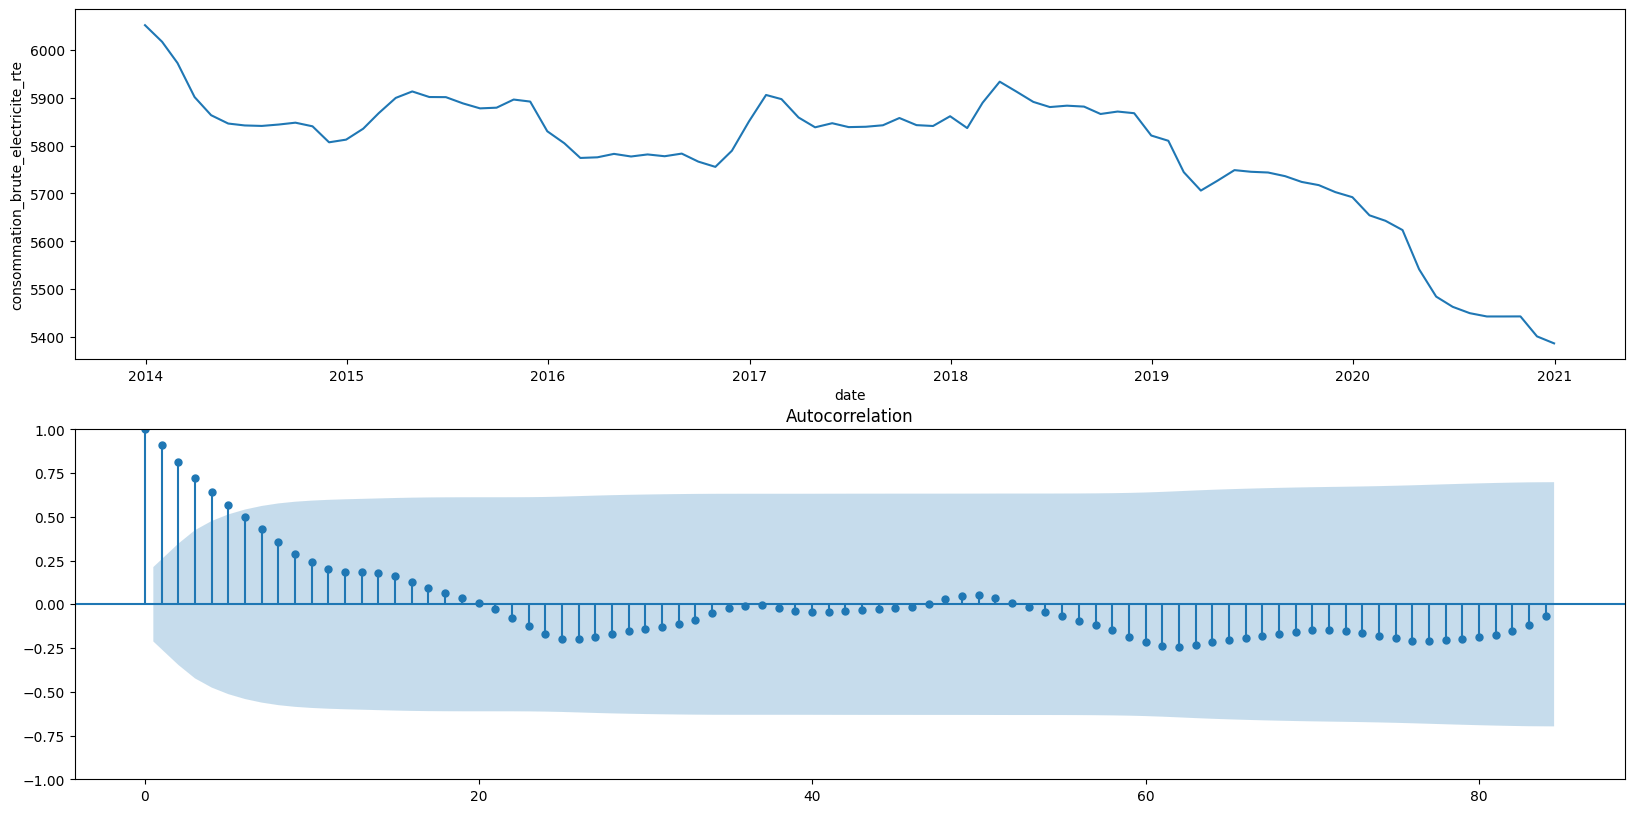

In [23]:
import seaborn as sns
import statsmodels.api as sm

fig = plt.figure(figsize=(20, 10))
subplot1 = fig.add_subplot(211)
subplot2 = fig.add_subplot(212)
sns.lineplot(serie_desaisonnalisee_split, ax=subplot1)
sm.graphics.tsa.plot_acf(serie_desaisonnalisee_split, lags=84, ax=subplot2) 
fig.show()

In [24]:
import statsmodels.api as sm

arima_model = sm.tsa.ARIMA(serie_desaisonnalisee_split, order=(2, 1, 1))

arima_model = arima_model.fit()

print(arima_model.summary())

                                       SARIMAX Results                                        
Dep. Variable:     consommation_brute_electricite_rte   No. Observations:                   85
Model:                                 ARIMA(2, 1, 1)   Log Likelihood                -381.379
Date:                                Mon, 18 Sep 2023   AIC                            770.757
Time:                                        15:16:02   BIC                            780.481
Sample:                                    12-31-2013   HQIC                           774.666
                                         - 12-31-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3066      0.136     -2.260      0.024      -0.573      -0.041
ar.

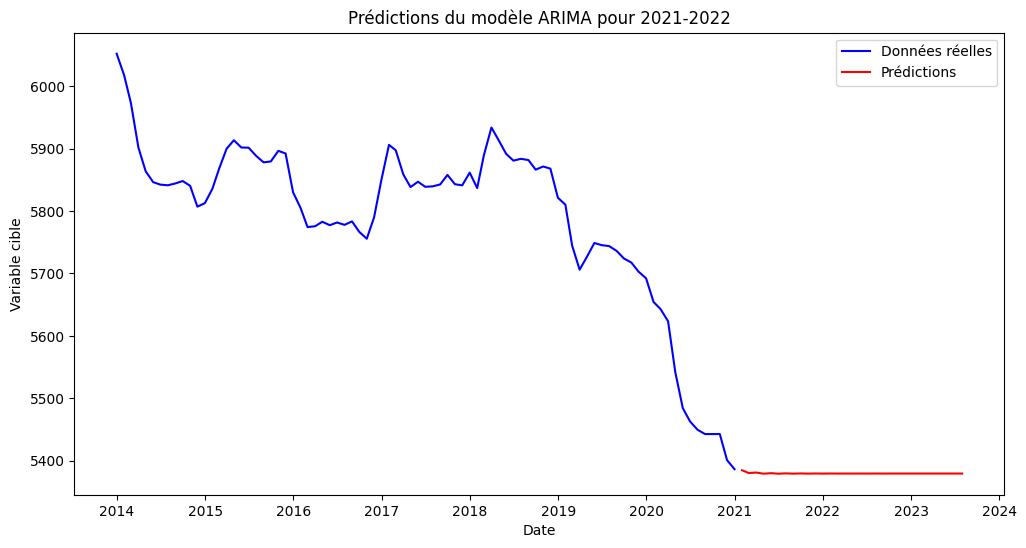

In [25]:
predictions = arima_model.predict(start=85,end=115)

# Afficher les prédictions par rapport aux données réelles
plt.figure(figsize=(12, 6))
plt.plot(serie_desaisonnalisee_split.index, serie_desaisonnalisee_split, label='Données réelles', color='blue')
plt.plot(predictions.index, predictions.values, label='Prédictions', color='red')
plt.xlabel('Date')
plt.ylabel('Variable cible')
plt.title('Prédictions du modèle ARIMA pour 2021-2022')
plt.legend()
plt.show()

### 11. A l’aide de statmodels et pmdarima, lancez un auto ARIMA sur la série désaisonnalisée.Comparez ce modèle avec le modèle précédent graphiquement puis en utilisant l’AIC


In [26]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
auto_arima = pm.auto_arima(serie_desaisonnalisee, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=None, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

auto_arima.summary()

/home/apprenant/miniconda3/envs/sklearn-env/lib/python3.8/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=11408.728, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13266.996, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11440.255, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11602.984, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13326.864, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11194.985, Time=1.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11435.348, Time=0.43 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11166.568, Time=0.99 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=11168.779, Time=0.61 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10025.074, Time=4.71 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11064.620, Time=1.63 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9907.316, Time=5.87 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11076.541, Time=4.09 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=inf, Time=2.75 sec

Best model:  ARIMA(3,1,3)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3469
Model:               SARIMAX(3, 1, 3)   Log Likelihood               -4945.658
Date:                Mon, 18 Sep 2023   AIC                           9907.316
Time:                        15:16:27   BIC                           9956.527
Sample:                    12-31-2013   HQIC                          9924.887
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1071      0.046      2.318      0.020       0.017       0.198
ar.L1          0.3736      0.014     27.596      0.000       0.347       0.400
ar.L2         -0.6306      0.006   -102.442      0.000      -0.643      -0.619
ar.L3          0.8130      0.013     61.638      0.000       0.787       0.839
ma.L1          0.4435      0.022     19.836      0.000       0.400       0.487
ma.L2          0.9610      0.013     72.821      0.000       0.935       0.987
ma.L3         -0.0178      0.022     -0.806      0.420      -0.061       0.025
sigma2         1.0260      0.024     42.019      0.000       0.978       1.074
===================================================================================
Ljung-Box (L1) (Q):                   1.39   Jarque-Bera (JB):                53.03
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

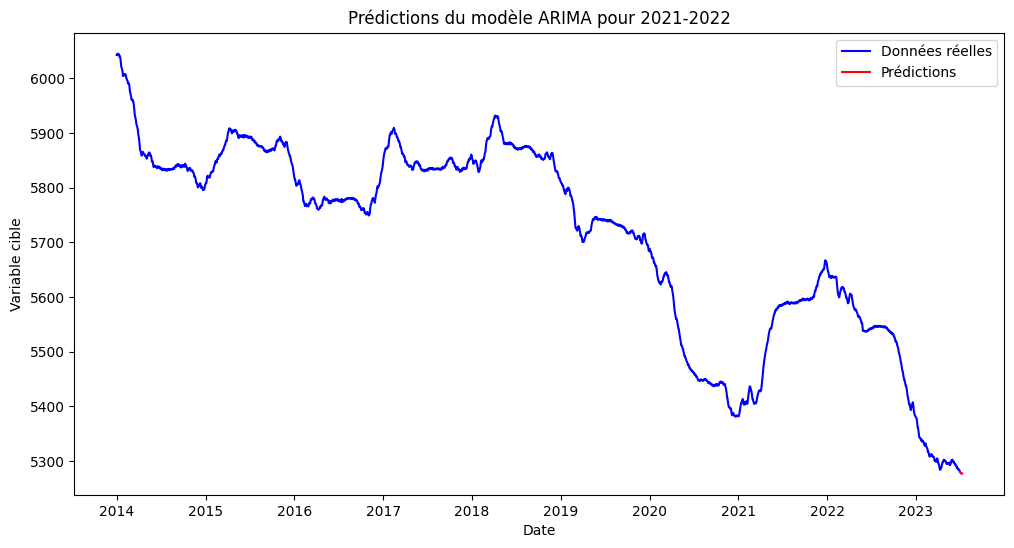

In [27]:
predictions = auto_arima.predict()

# Afficher les prédictions par rapport aux données réelles
plt.figure(figsize=(12, 6))
plt.plot(serie_desaisonnalisee.index, serie_desaisonnalisee, label='Données réelles', color='blue')
plt.plot(predictions.index, predictions.values, label='Prédictions', color='red')
plt.xlabel('Date')
plt.ylabel('Variable cible')
plt.title('Prédictions du modèle ARIMA pour 2021-2022')
plt.legend()
plt.show()

### 12. Comment pourrait-on ajouter à nouveau la composante saisonnière à partir du résultat obtenu.

### 13. Lancez un modèle auto-Arima sur la série originale journalière en incluant les paramètres saisonniers. Vous devriez rencontrer des problèmes. Documentez vous essayer de comprendre ce qu’il se passe.

In [28]:
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
auto_arima = pm.auto_arima(df_month, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=None, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

auto_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=1862.810, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2075.023, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1803.259, Time=0.33 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1902.781, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2543.040, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1934.640, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1821.346, Time=0.59 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1833.142, Time=0.36 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=1878.748, Time=0.11 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1830.356, Time=0.79 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=2074.918, Time=0.05 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=1834.796, Time=0.33 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=1802.432, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1908.194, Time=0.06 sec
 ARIMA(1,0,1)(2,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  126
Model:             SARIMAX(2, 0, 3)x(1, 0, [1], 12)   Log Likelihood                -871.946
Date:                              Mon, 18 Sep 2023   AIC                           1759.892
Time:                                      15:17:08   BIC                           1782.582
Sample:                                  01-31-2013   HQIC                          1769.110
                                       - 06-30-2023                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4237      0.224      6.345      0.000       0.984       1.863
ar.L2         -0.4252      0.219     -1.940      0.052      -0.855       0.004
ma.L1         -0.7169      0.231     -3.100      0.002      -1.170      -0.264
ma.L2         -0.1715      0.127     -1.351      0.177      -0.420       0.077
ma.L3         -0.0518      0.157     -0.330      0.741      -0.359       0.256
ar.S.L12       0.9975      0.004    226.433      0.000       0.989       1.006
ma.S.L12      -0.8287      0.134     -6.198      0.000      -1.091      -0.567
sigma2      4.271e+04   5751.315      7.426      0.000    3.14e+04     5.4e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 3.96
Prob(Q):                              0.73   Prob(JB):                         0.14
Heteroskedasticity (H):               1.29   Skew:                            -0.38
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

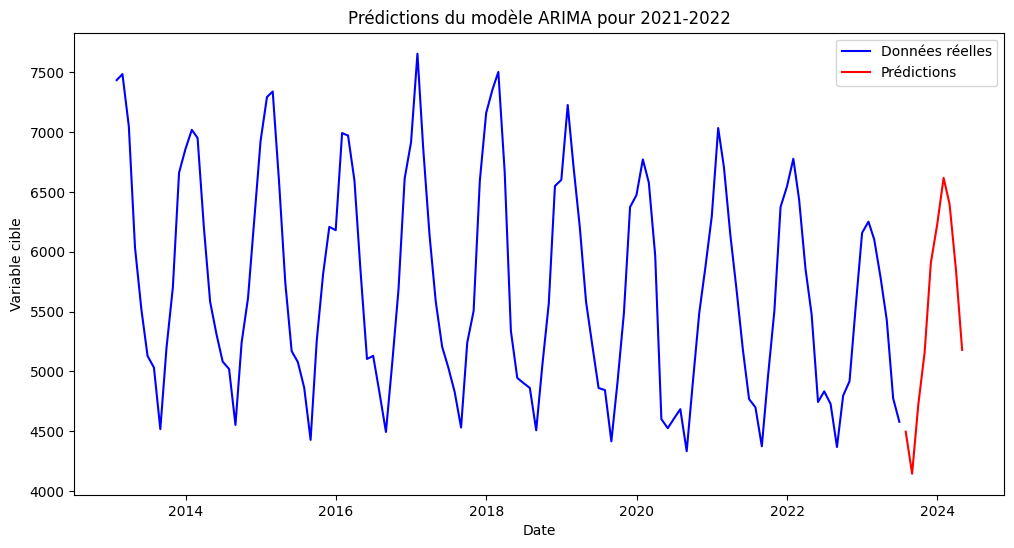

In [29]:
predictions = auto_arima.predict()

# Afficher les prédictions par rapport aux données réelles
plt.figure(figsize=(12, 6))
plt.plot(df_month.index, df_month, label='Données réelles', color='blue')
plt.plot(predictions.index, predictions.values, label='Prédictions', color='red')
plt.xlabel('Date')
plt.ylabel('Variable cible')
plt.title('Prédictions du modèle ARIMA pour 2021-2022')
plt.legend()
plt.show()

### Prophet

In [30]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [31]:
model = Prophet(interval_width=0.95)

df = pd.read_csv('conso-hdf.csv', index_col=0)

# Convertir la colonne 'date' en type datetime si ce n'est pas déjà fait
df['date'] = pd.to_datetime(df['date'])

# Regrouper par mois et calculer la moyenne de la colonne 'consommation'
df_month = df.resample('M', on='date').mean().reset_index()

# Renommer la colonne 'date' en 'ds' si nécessaire
df_month = df_month.rename(columns={"date": "ds", "consommation_brute_electricite_rte":'y'})

model.fit(df_month)
future = model.make_future_dataframe(periods=24,freq='M')
future.tail()

/tmp/ipykernel_21664/3447637052.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_month = df.resample('M', on='date').mean().reset_index()
15:17:09 - cmdstanpy - INFO - Chain [1] start processing
15:17:09 - cmdstanpy - INFO - Chain [1] done processing


,ds
145,2025-02-28
146,2025-03-31
147,2025-04-30
148,2025-05-31
149,2025-06-30


In [32]:
forecast = model.predict(future)

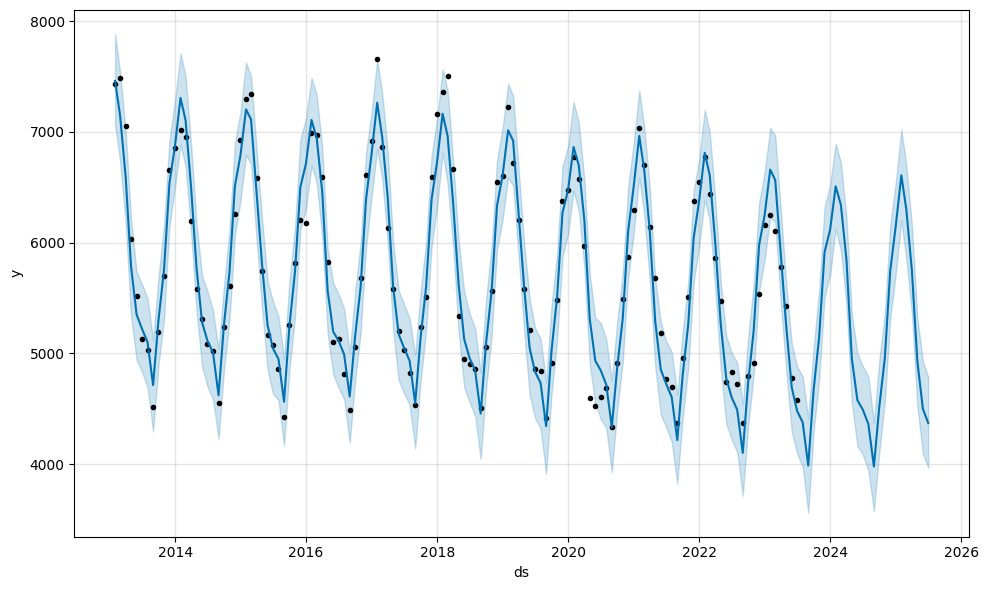

In [33]:
fig1 = model.plot(forecast)

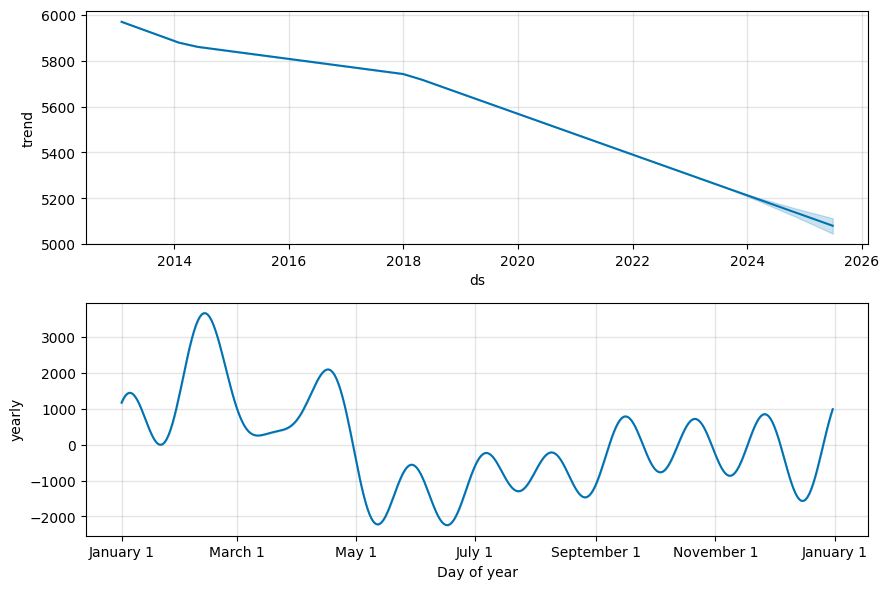

In [34]:
fig2 = model.plot_components(forecast)

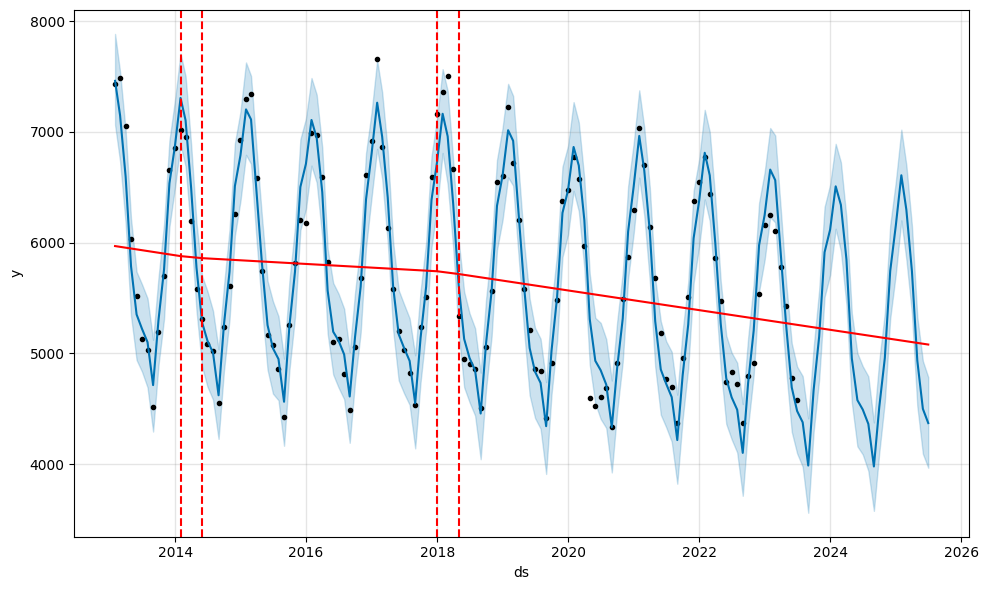

In [35]:
from prophet.plot import add_changepoints_to_plot

fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)

15:17:10 - cmdstanpy - INFO - Chain [1] start processing


15:17:10 - cmdstanpy - INFO - Chain [1] done processing


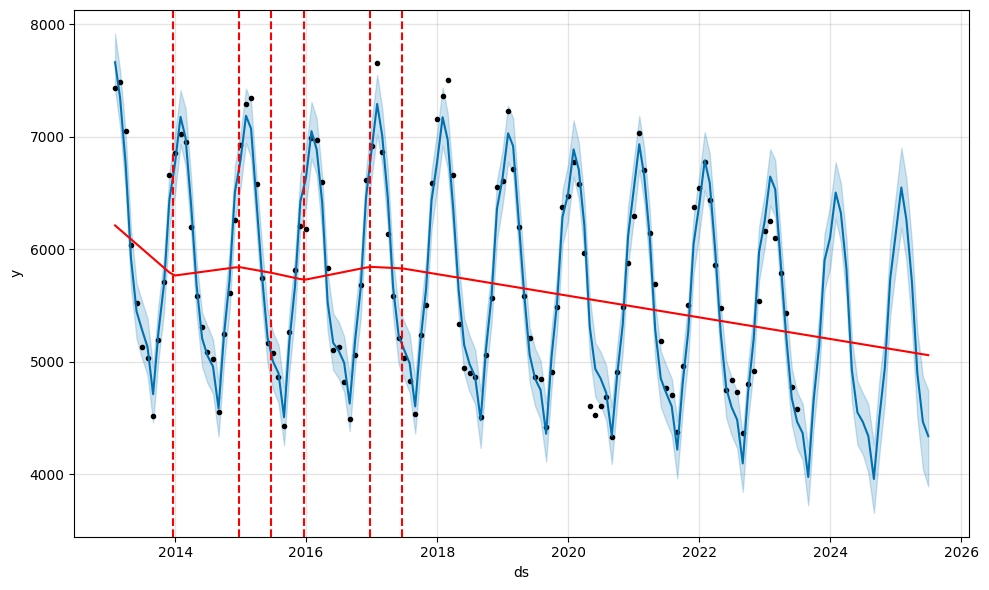

In [36]:
m = Prophet(daily_seasonality=False,
changepoints=['2013-12-21', '2014-06-21', '2014-12-21', '2015-06-21', '2015-12-21', '2016-06-21', '2016-12-21', '2017-06-21'],
changepoint_prior_scale=1)
m = m.fit(df_month)
forecast = m.predict(future)
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)